# Training analysis for DeepRacer

This notebook has been built based on the `DeepRacer Log Analysis.ipynb` provided by the AWS DeepRacer Team. It has been reorganised and expanded to provide new views on the training data without the helper code which was moved into utility `.py` files.

## Usage

I have expanded this notebook from to present how I'm using this information. It contains descriptions that you may find not that needed after initial reading. Since this file can change in the future, I recommend that you make its copy and reorganize it to your liking. This way you will not lose your changes and you'll be able to add things as you please.

**This notebook isn't complete.** What I find interesting in the logs may not be what you will find interesting and useful. I recommend you get familiar with the tools and try hacking around to get the insights that suit your needs.

## Contributions

As usual, your ideas are very welcome and encouraged so if you have any suggestions either bring them to [the AWS DeepRacer Community](http://join.deepracing.io) or share as code contributions.

## Training environments

Depending on whether you're running your training through the console or using the local setup, and on which setup for local training you're using, your experience will vary. As much as I would like everything to be taylored to your configuration, there may be some problems that you may face. If so, please get in touch through [the AWS DeepRacer Community](http://join.deepracing.io).

## Requirements

Before you start using the notebook, you will need to install some dependencies. If you haven't yet done so, have a look at [The README.md file](/edit/README.md#running-the-notebooks) to find what you need to install.

Apart from the install, you also have to configure your programmatic access to AWS. Have a look at the guides below, AWS resources will lead you by the hand:

AWS CLI: https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-configure.html

Boto Configuration: https://boto3.amazonaws.com/v1/documentation/api/latest/guide/configuration.html

## Credits

I would like to thank [the AWS DeepRacer Community](http://join.deepracing.io) for all the feedback about the notebooks. If you'd like, follow [my blog](https://codelikeamother.uk) where I tend to write about my experiences with AWS DeepRacer.

# Log Analysis

Let's get to it.

## Imports

Run the imports block below:

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import glob
import os.path

%matplotlib inline

#Shapely Library
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString

#Plotly Library
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

from python import track_utils as tu
from python import cw_utils as cw
from python import log_analysis as la
from python import plotly_graph_utils as pg

import math
from pathlib import Path

# Make sure your boto version is >= '1.9.133'
cw.boto3.__version__

'1.14.39'

This block below has been prepared in case you would like to make some changes to the utility code that comes with this notebook. It will reload track_utlis.py, log_analysis.py and cw_utils.py without the need to reload the notebook. In normal usage of the notebook you will not need it.

In [40]:
# reload log_analysis and the rest of stuff here if needed
# (handy for code updates in utils, doesn't break anything if no changes)
import importlib
importlib.reload(la)
importlib.reload(cw)
importlib.reload(tu)
importlib.reload(pg)

<module 'python.plotly_graph_utils' from 'C:\\Users\\Rogue\\Desktop\\deepracer\\deepracer-pirates-log-analysis\\Notebooks\\python\\plotly_graph_utils.py'>

## Load waypoints for the track you want to run analysis on

The track waypoint files usually show up as new races start. Be sure to check for them in repository updates. You only need to load them in the block below.

These files represent the coordinates of characteristic points of the track - the center line, inside border and outside border. Their main purpose is to visualise the track in images below. One thing that you may want to remember is that at the moment not all functions below work with all values of the coordinates. Especially some look awkward with bigger tracks or with negative coordinates. Usually there is an explanation on what to do to fix the view.

The naming of the tracks is not super consistent. I'm also not sure all of them are available in the console or locally. You may want to know that:
* London_Loop and Virtual_May19_Train_track - are the AWS DeepRacer Virtual League London Loop tracks
* Tokyo - is the AWS DeepRacer Virtual League Kumo Torakku track
* New_York - are the AWS DeepRacer Virtual League Empire City training and evaluation tracks
* China - are the AWS Deepracer Virtual League Shanghai Sudu training and evaluation tracks
* reinvent_base - is the re:Invent 2019 racing track

There are also other tracks that you may want to explore. Each of them has its own properties that you might find useful for your model.

Remeber that evaluation npy files are a community effort to visualise the tracks in the trainings, they aren't 100% accurate.

Tracks Available:

In [41]:
# Conveniently list available tracks to analyze
available_track_files = glob.glob("../Tracks/**.npy")
available_track_names = list(map(lambda x: os.path.basename(x).split('.npy')[0], available_track_files))
available_track_names

['bowtie', 'reinvent_base']

In [42]:
# Configuration
TRACK_NAME = "reinvent_base"
log_dir = "pirates-final-v16-rogue-2"

#Profile for downloading logs from CloudWatch
PROFILE = "adfs"

#DRFC number of workers for console training set this to 1
workers = 1

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 300)

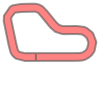

In [43]:
l_center_line, l_inner_border, l_outer_border, road_poly = tu.load_track(TRACK_NAME, "../")
road_poly

In [44]:
# Plotly plot configuration
plotly_config = {}
plotly_config["height"]=600 #Track scaling height
plotly_config["width"]=900 #Track scaling width
plotly_config["track_name"]=TRACK_NAME

## Get the logs

Depending on which way you are training your model, you will need a different way to load the data.

**AWS DeepRacer Console**
Download the logs from the Deepracer Console to the Logs folder. Give the name of the directory for log which you want to parse in the variable log_dir.

**DeepRacer for Dummies/ARCC local training**
Those two setups come with a container that runs Jupyter Notebook (as you noticed if you're using one of them and reading this text). Logs are stored in `/logs/` and you just need to point at the latest file to see the current training. The logs are split for long running training if they exceed 500 MB. The log loading method has been extended to support that.

**Chris Rhodes' repo**
Chris repo doesn't come with logs storage out of the box. I would normally run `docker logs dr > /path/to/logfile` and then load the file.

Below I have prepared a section for each case. In each case you can analyse the logs as the training is being run, just in case of the Console you may need to force downloading of the logs as the `cw.download_log` method has a protection against needless downloads.

Select your preferred way to get the logs below and you can get rid of the rest.

In [45]:
def download_logs(robomaker_stream_name):
    robomakers=[]
    for i in range(len(robomaker_stream_name)):
        robomaker_fname = "robomaker-"+str(i+1)+".log"
        robomaker_fname = log_path+robomaker_fname
        robomakers.append(robomaker_fname)
        cw.download_log(fname=robomaker_fname, stream_name=robomaker_stream_name[i], log_group=LOG_GROUP, force=True, profile=PROFILE)
    return robomakers

In [46]:
# # Deepracer for Cloud
# LOG_GROUP = "/deepracer-for-cloud"
# log_path = "../Logs/"+log_dir+"/logs/training/"
# Path(log_path).mkdir(parents=True, exist_ok=True)
# sagemaker_fname = log_dir + "-drfc-sagemaker.log"
# sagemaker_fname = log_path + sagemaker_fname

# robomaker_stream_name=[]

# #Append depending on number of workers.
# robomaker_stream_name.append("stream-name1")
# robomaker_stream_name.append("stream-name2")
# robomaker_stream_name.append("stream-name3")
# sagemaker_stream_name = "deepracer-0_rl_coach.1.1jovv09fgns6asky9ivn0lhn2"

# robomakers = download_logs(robomaker_stream_name)
# robomaker_fname = robomakers[0]
# cw.download_log(fname=sagemaker_fname, stream_name=sagemaker_stream_name, log_group=LOG_GROUP, force=True, profile=PROFILE)
# (robomakers,sagemaker_fname)

In [47]:
# AWS DeepRacer Console
sagemaker_fname =  glob.glob("../Logs/"+log_dir+"/logs/training/**sagemaker.log")[0]
robomaker_fname = glob.glob("../Logs/"+log_dir+"/logs/training/**robomaker.log")[0]
robomakers = [robomaker_fname]
sagemaker_fname,robomaker_fname

('../Logs/pirates-final-v16-rogue-2/logs/training\\training-20200815050146-GkoCn8GBS_W7dYccKOktDQ-sagemaker.log',
 '../Logs/pirates-final-v16-rogue-2/logs/training\\training-20200815050147-GkoCn8GBS_W7dYccKOktDQ-robomaker.log')

## Load the trace training log

Now that the data is downloaded, we need to load it into memory. We will first read it from file and then convert to data frames in Pandas. [Pandas](https://pandas.pydata.org/) is a Python library for handling and analysing large amounts of data series. Remember this name, you may want to learn more about how to use it to get more information that you would like to get from the logs. Examples below are hardly scratching the surface.

One important information to enter is the setting of your Episodes per iteration hyperparameter. This is used to group the episodes into iterations. This information is valuable when later looking at graphs showing how the training progresses per iteration. You can use it to detect which iteration gave you better outcomes and, if in local training, you could move to that iteration's outcome for submissions in the AWS DeepRacer League or  for continuing the training.

The log files you have just gathered above have lines like this one:
```
SIM_TRACE_LOG:799,111,1.7594,4.4353,3.0875,-0.26,2.50,2,1.0000,False,True,71.5802,49,17.67,1555554451.1110387
```
This is all that matters for us. The first two are some tests I believe and when loading they get skipped, then each next line has the following fields:
* episode number
* step number
* x coordinate
* y coordinate
* yaw of the car (where the car is heading)
* decision about turning (turn value from your action space)
* decision about throttle (speed value from your action space)
* decision index (value from your action space)
* reward value
* is the car going backwards
* are all wheels on track?
* progress in the lap
* closest waypoint
* track length
* timestamp

`la.load_data` and then `la.convert_to_pandas` read it and prepare for your usage. Sorting the values may not be needed, but I have experienced under some circumstances that the log lines were not ordered properly.

In [48]:
def parse_robomaker_logs_hyperparameters(robomaker_fname, hyperparameter_name):
    hyperparameter_name = hyperparameter_name.replace('_', '[_]')
    os_cmd = "cat %s | grep -E '^[ ]+[\"]%s[\"][:]' | cut -d':' -f2 | cut -d',' -f1 | sed -e 's/^[ ]*//g'" % (robomaker_fname, hyperparameter_name)
    os_output = !$os_cmd
    return os_output[0]

# use this manually in windows
# EPISODES_PER_ITERATION = 40

EPISODES_PER_ITERATION = int(parse_robomaker_logs_hyperparameters(robomaker_fname, 'num_episodes_between_training'))
NUM_EPOCHS = int(parse_robomaker_logs_hyperparameters(robomaker_fname, 'num_epochs'))

print ('EPISODES_PER_ITERATION: %s' % EPISODES_PER_ITERATION)
EPISODES_PER_ITERATION = int(EPISODES_PER_ITERATION/(workers))
print ('EPISODES_PER_ITERATION per robomaker: %s' % EPISODES_PER_ITERATION)
print ('NUM_EPOCHS: %s' % NUM_EPOCHS)

EPISODES_PER_ITERATION: 20
EPISODES_PER_ITERATION per robomaker: 20
NUM_EPOCHS: 10


In [49]:
cst = (workers-1)*EPISODES_PER_ITERATION
for w in range(workers):
    data = la.load_data(robomakers[w])
    wdf = la.convert_to_pandas(data, episodes_per_iteration=EPISODES_PER_ITERATION)
    wdf = wdf.sort_values(['episode', 'steps'])
    wdf['episode'] += (wdf['iteration']-1)*cst+w*EPISODES_PER_ITERATION
    if w == 0:
        df = wdf.copy()
    else :        
        df = pd.concat([df, wdf], ignore_index=True)
df = df.sort_values(['episode', 'steps'])

# personally I think normalizing can mask too high rewards so I am commenting it out,
# but you might want it.
# la.normalize_rewards(df)

#Uncomment the line of code below to evaluate a different reward function
# la.new_reward(df, l_center_line, 'reward.new_reward') #, verbose=True)

### Code to cut down the training till the specified checkpoint episode
Ex : If Best Checkpoint is at episode = 3250, cut down training data until that episode

In [50]:
# checkpoint_ep = 3250
# ep = df[df['episode']==checkpoint_ep]
# step_no = int(ep.iloc[[-1]].index.tolist()[0])
# df = df.iloc[0:step_no]

## New reward

Note the last line above: it takes a reward class from log-analysis/rewards, imports it, instantiates and recalculates reward values based on the data from the log. This lets you do some testing before you start training and rule out some obvious things.

*If you find this confusing, don't worry, because it is confusing. You can safely ignore it for now and come back to it later.*

This operation is possible because the logs contain all information needed to recreate the params for a given step. That said some could be implemented better and some were ignored for now and should be implemented.

The sample reward mentioned in that line is located in `log-analysis/rewards/reward_sample.py` and looks like this:

```
from time import time


class Reward:
    def __init__(self, verbose=False):
        self.previous_steps = None
        self.initial_time = None
        self.verbose = verbose

    @staticmethod
    def get_time(params):
        # remember: this will not return time before
        # the first step has completed so the total
        # time for lap will be lower by about 0.2s
        return params.get('timestamp', None) or time()

    def reward_function(self, params):
        if self.previous_steps is None \
                or self.previous_steps > params['steps']:
            # new lap!
            self.initial_time = self.get_time(params)
        else:
            # we're continuing a lap
            pass

        steering_factor = 1.0

        if abs(params['steering_angle']) > 14:
            steering_factor = 0.7

        reward = float(steering_factor)

        self.previous_steps = params['steps']

        if self.verbose:
            print(params)

        return reward


reward_object = Reward()


def reward_function(params):
    return reward_object.reward_function(params)

```

After some imports a class is declared, it's called `Reward`, then the class is instantiated and a function `reward_function` is declared. This somewhat bloated structure has a couple benefits:
* It works in console/local training for actual training
* It lets you reload the definition for class Reward and retry the reward function multiple times after changes without much effort
* If you want to rely on state carried over between the steps, it's all contained in a reward object 

The reward class hides two or three tricks for you:
* `get_time` lets you abstract from machine time in log analysis - the supporting code adds one extra param, `timestamp`. That lets you get the right time value in new_reward function
* the first condition allows detecting the beginning of an episode or even start of training you can use it for some extra operations between the episodes
* `verbose` can be used to provide some noisier prints in the reward function - you can switch them on when loading the reward function above.

Just remember: not all params are provided, you are free to implement them and raise a Pull Request for log_analysis.df_to_params method.

If you just wrap your reward function like in the above example, you can use it in both log analysis notebook and the training.

Final warning: there is a loss of precision in the logs (rounded numbers) and also potentially potential bugs. If you find any, please fix, please report.

## Graphs

The original notebook has provided some great ideas on what could be visualised in the graphs. Below examples are a slightly extended version. Let's have a look at what they are presenting and what this may mean to your training.

### Training progress

As you have possibly noticed by now, training episodes are grouped into iterations and this notebook also reflects it. What also marks it are checkpoints in the training. After each iteration a set of ckpt files is generated - they contain outcomes of the training, then a model.pb file is built based on that and the car begins a new iteration. Looking at the data grouped by iterations may lead you to a conclusion, that some earlier checkpoint would be a better start for a new training. While this is limited in the AWS DeepRacer Console, with enough disk space you can keep all the checkpoints along the way and use one of them as a start for new training (or even as a submission to a race).

While the episodes in a given iteration are a mixture of decision process and random guesses, mean results per iteration may show a specific trend. Mean values are accompanied by standard deviation to show the concentration of values around the mean.

#### Rewards per Iteration

You can see these values as lines or dots per episode in the AWS DeepRacer console. When the reward goes up, this suggests that a car is learning and improving with regards to a given reward function. **This does not have to be a good thing.** If your reward function rewards something that harms performance, your car will learn to drive in a way that will make results worse.

At first the rewards just grow if the progress achieved grows. Interesting things may happen slightly later in the training:

* The reward may go flat at some level - it might mean that the car can't get any better. If you think you could still squeeze something better out of it, review the car's progress and consider updating the reward function, the action space, maybe hyperparameters, or perhaps starting over (either from scratch or from some previous checkpoint)
* The reward may become wobbly - here you will see it as a mesh of dots zig-zagging. It can be a gradually growing zig-zag or a roughly stagnated one. This usually means the learning rate hyperparameter is too high and the car started doing actions that oscilate around some local extreme. You can lower the learning rate and hope to step closer to the extreme. Or run away from it if you don't like it
* The reward plunges to near zero and stays roughly flat - I only had that when I messed up the hyperparameters or the reward function. Review recent changes and start training over or consider starting from scratch

The Standard deviation says how close from each other the reward values per episode in a given iteration are. If your model becomes reasonably stable and worst performances become better, at some point the standard deviation may flat out or even decrease. That said, higher speeds usually mean there will be areas on track with higher risk of failure. This may bring the value of standard deviation to a higher value and regardless of whether you like it or not, you need to accept it as a part of fighting for significantly better times.

#### Time per iteration

I'm not sure how useful this graph is. I would worry if it looked very similar to the reward graph - this could suggest that slower laps will be getting higher rewards. But there is a better graph for spotting that below.

#### Progress per Iteration

This graph usually starts low and grows and at some point it will get flatter. The maximum value for progress is 100% so it cannot grow without limits. It usually shows similar initial behaviours to reward and time graphs. I usually look at it when I alter an action in training. In such cases this graph usually dips a bit and then returns or goes higher.

#### Total reward per episode

This graph has been taken from the orignal notebook and can show progress on certain groups of behaviours. It usually forms something like a triangle, sometimes you can see a clear line of progress that shows some new way has been first taught and then perfected.

#### Mean completed lap times per iteration

Once we have a model that completes laps reasonably often, we might want to know how fast the car gets around the track. This graph will show you that. I use it quite often when looking for a model to shave a couple more miliseconds. That said it has to go in pair with the last one:

#### Completion rate per iteration

It represents how big part of all episodes in an iteration is full laps. The value is from range [0, 1] and is a result of deviding amount of full laps in iteration by amount of all episodes in iteration. I say it has to go in pair with the previous one because you not only need a fast lapper, you also want a race completer.

The higher the value, the more stable the model is on a given track.

### Stats for all laps

Previous graphs were mainly focused on the state of training with regards to training progress. This however will not give you a lot of information about how well your reward function is doing overall.

In such case `scatter_aggregates` may come handy. It comes with three types of graphs:
* progress/steps/reward depending on the time of an episode - of this I find reward/time and new_reward/time especially useful to see that I am rewarding good behaviours - I expect the reward to time scatter to look roughly triangular
* histograms of time and progress - for all episodes the progress one is usually quite handy to get an idea of model's stability
* progress/time_if_complete/reward to closest waypoint at start - these are really useful during training as they show potentially problematic spots on track. It can turn out that a car gets best reward (and performance) starting at a point that just cannot be reached if the car starts elsewhere, or that there is a section of a track that the car struggles to get past and perhaps it's caused by an aggressive action space or undesirable behaviour prior to that place

Side note: `time_if_complete` is not very accurate and will almost always look better for episodes closer to 100% progress than in case of those 50% and below.

In [51]:
simulation_agg = la.simulation_agg(df)
pg.plot_progress_reward_distribution(simulation_agg)

new reward not found, using reward as its values


Number of episodes =  579
Number of iterations =  29


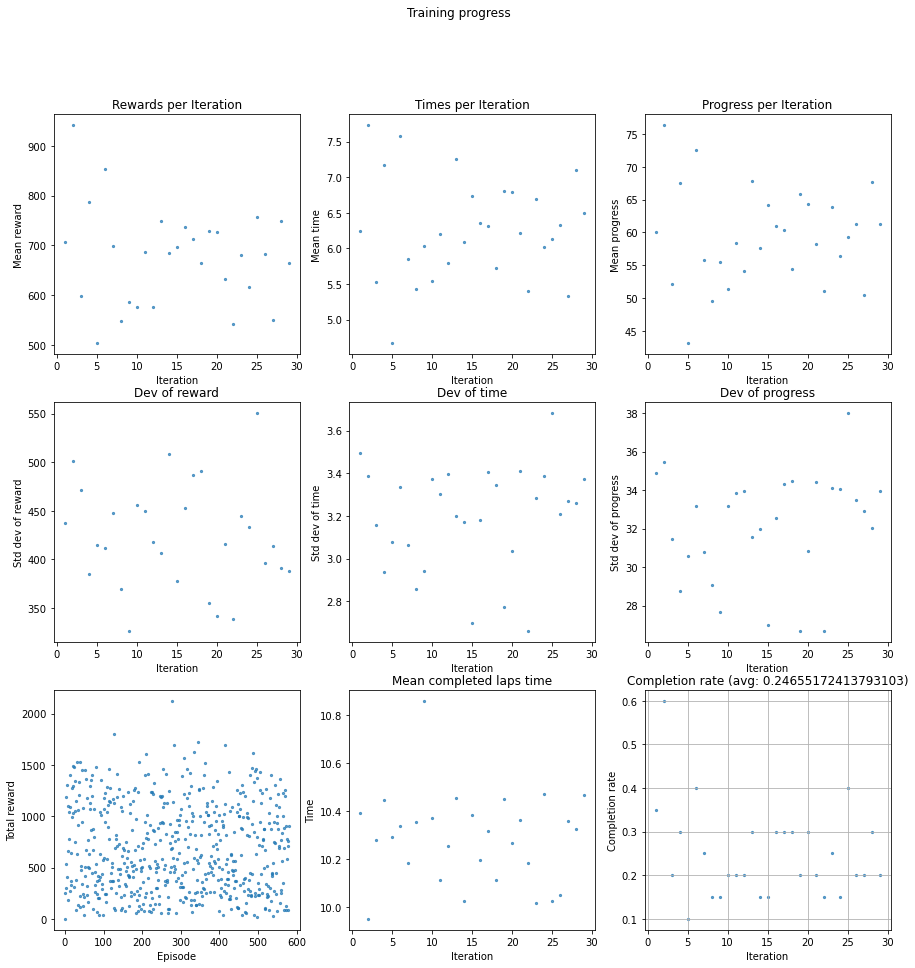

<Figure size 432x288 with 0 Axes>

In [52]:
la.analyze_training_progress(simulation_agg, title='Training progress')

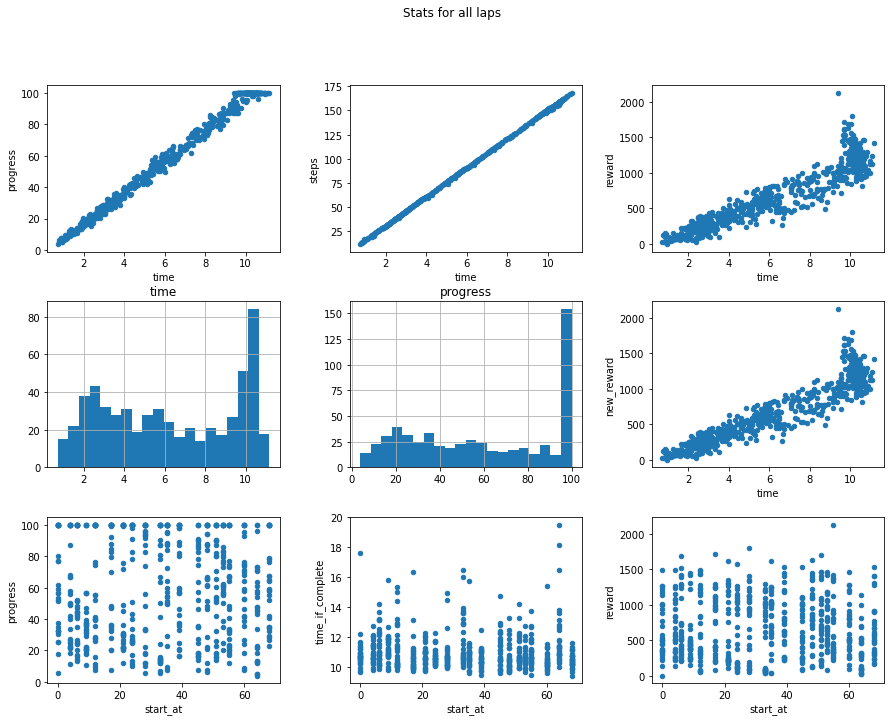

<Figure size 432x288 with 0 Axes>

In [53]:
la.scatter_aggregates(simulation_agg, 'Stats for all laps')

### Stats for complete laps
The graphs here are same as above, but now I am interested in other type of information:
* does the reward scatter show higher rewards for lower completion times? If I give higher reward for a slower lap it might suggest that I am training the car to go slow
* what does the time histogram look like? With enough samples available the histogram takes a normal distribution graph shape. The lower the mean value, the better the chance to complete a fast lap consistently. The longer the tails, the greater the chance of getting lucky in submissions
* is the car completing laps around the place where the race lap starts? Or does it only succeed if it starts in a place different to the racing one?

143


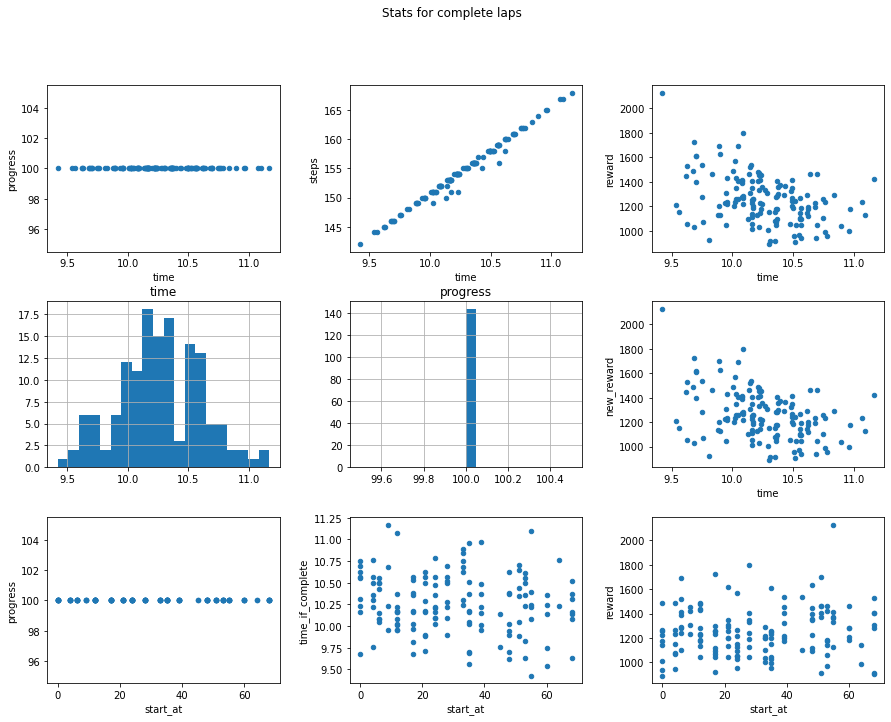

<Figure size 432x288 with 0 Axes>

In [54]:
complete_ones = simulation_agg[simulation_agg['progress']==100]
print(len(complete_ones))
if complete_ones.shape[0] > 0:
    la.scatter_aggregates(complete_ones, 'Stats for complete laps')
else:
    print('No complete laps yet.')

In [55]:
pg.plot_time_hist(complete_ones)

In [56]:
pg.plot_complete_lap_analysis(complete_ones)

In [57]:
pg.plot_distribution(complete_ones,column="steps",percent=25)

In [58]:
pg.plot_distribution(complete_ones,column="time",percent=25)

In [59]:
pg.plot_reward_distribution(df,percent=25)

In [60]:
pg.plot_reward_hist(df)

In [61]:
# Retrieve policy training data from the SageMaker Log file
trn_data = la.parse_sagemaker_logs(sagemaker_fname)
pg.plot_training_metrics(trn_data)
pg.plot_training_metrics(trn_data, "surrogate_loss")

### Categories analysis
We're going back to comparing training results based on the training time, but in a different way. Instead of just scattering things in relation to iteration or episode number, this time we're grouping episodes based on a certaing information. For this we use function:
```
analyze_categories(panda, category='quintile', groupcount=5, title=None)
```
The idea is pretty simple - determine a way to cluster the data and provide that as the `category` parameter (alongside the count of groups available). In the default case we take advantage of the aggregated information to which quintile an episode belongs and thus build buckets each containing 20% of episodes which happened around the same time during the training. If your training lasted for five hours, this would show results grouped per each hour.

A side note: if you run the function with `category='start_at'` and `groupcount=20` you will get results based on the waypoint closest to the starting point of an episode. If you need to, you can introduce other types of categories and reuse the function.

The graphs are similar to what we've seen above. I especially like the progress one which shows where the model tends to struggle and whether it's successful laps rate is improving or beginning to decrease. Interestingly, I also had cases where I saw the completion drop on the progress rate only to improve in a later quintile, but with a better time graph.

A second side note: if you run this function for `complete_ones` instead of `simulation_agg`, suddenly the time histogram becomes more interesting as you can see whether completion times improve.

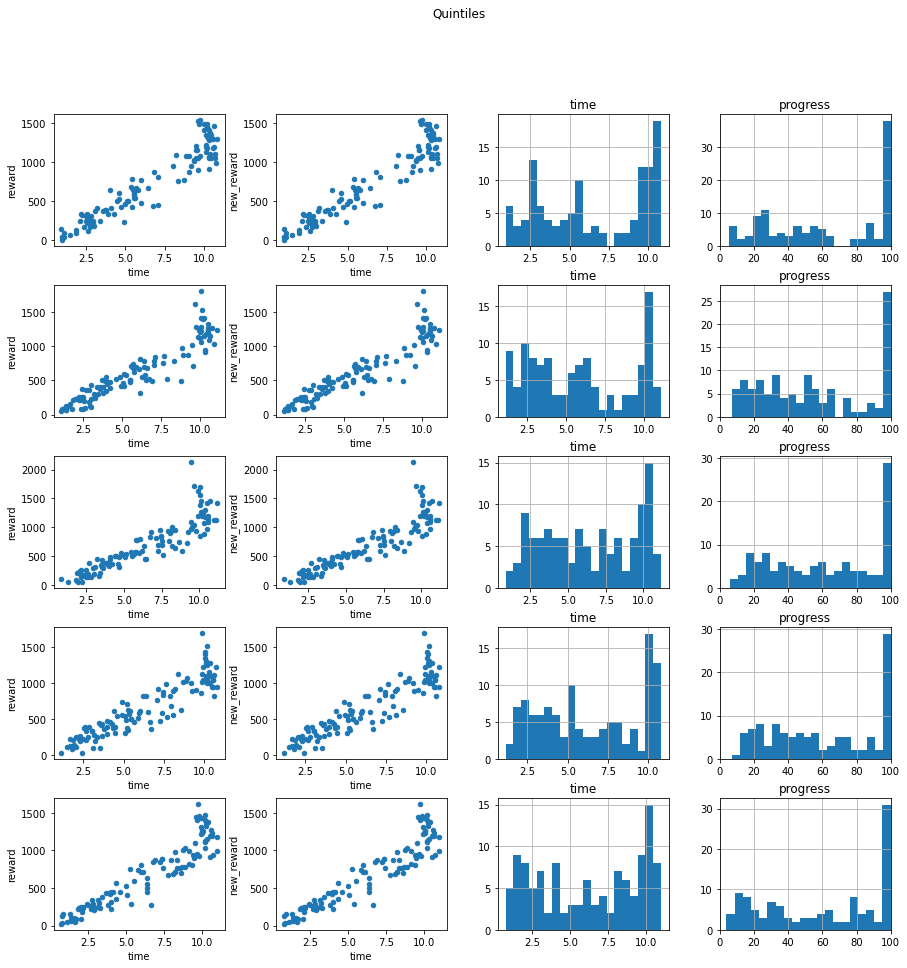

<Figure size 432x288 with 0 Axes>

In [62]:
la.analyze_categories(simulation_agg, title='Quintiles')

## Data in tables

While a lot can be seen in graphs that cannot be seen in the raw numbers, the numbers let us get into more detail. Below you will find a couple examples. If your model is behaving the way you would like it to, below tables may provide little added value, but if you struggle to improve your car's performance, they may come handy. In such cases I look for examples where high reward is giving to below-expected episode and when good episodes are given low reward.

You can then take the episode number and scatter it below, and also look at reward given per step - this can in turn draw your attention to some rewarding anomalies and help you detect some unexpected outcomes in your reward function.

There is a number of ways to select the data for display:
* `nlargest`/`nsmallest` lets you display information based on a specific value being highest or lowest
* filtering based on a field value, for instance `df[df['episode']==10]` will display only those steps in `df` which belong to episode 10
* `head()` lets you peek into a dataframe

There isn't a right set of tables to display here and the ones below may not suit your needs. Get to know Pandas more and have fun with them. It's almost as addictive as DeepRacer itself.

The examples have a short comment next to them explaining what they are showing.

In [63]:
# View ten best rewarded episodes in the training
simulation_agg.nlargest(100, 'new_reward')

iteration  episode  steps  start_at  progress       time  new_reward  \
276         14      276    142        55  100.0000   9.423167   2124.8643   
128          7      128    152        28  100.0000  10.089070   1798.7265   
345         18      345    146        17  100.0000   9.680221   1720.8115   
414         21      414    149        51  100.0000   9.887256   1694.9633   
282         15      282    151         6  100.0000  10.043586   1693.1090   
333         17      333    149        48  100.0000   9.897605   1629.3098   
486         25      486    146        21  100.0000   9.704311   1613.5395   
210         11      210    146        35  100.0000   9.700843   1610.6696   
307         16      307    149        24  100.0000  10.024356   1566.9913   
32           2       32    147        45  100.0000   9.751624   1533.5901   
191         10      191    153        39  100.0000  10.150842   1532.5104   
39           2       39    145        68  100.0000   9.629026   1527.5512   
362         19      362    153         6  100.0000  10.145994   1520.9909   
20           2       20    146         0  100.0000   9.679460   1487.0421   
24           2       24    151        12  100.0000  10.009455   1483.1627   
81           5       81    154         4  100.0000  10.214596   1482.7056   
484         25      484    154        12  100.0000  10.220218   1474.5006   
114          6      114    160        51  100.0000  10.639807   1463.8407   
317         16      317    152        60  100.0000  10.139032   1461.4346   
254         13      254    161        51  100.0000  10.698175   1460.4472   
495         25      495    148        53  100.0000   9.828892   1459.7918   
43           3       43    154         9  100.0000  10.233917   1452.2336   
51           3       51    154        39  100.0000  10.218046   1451.2480   
493         25      493    145        48  100.0000   9.620241   1442.9337   
424         22      424    151        12  100.0000  10.026715   1433.2374   
504         26      504    150        12  100.0000   9.957385   1429.2891   
323         17      323    168         9  100.0000  11.166543   1421.8134   
215         11      215    151        53  100.0000  10.231217   1416.6398   
136          7      136    152        55  100.0000  10.081739   1416.0693   
262         14      262    158         6  100.0000  10.496273   1415.0033   
71           4       71    156        39  100.0000  10.364656   1407.0834   
14           1       14    151        51  100.0000  10.046905   1405.9861   
479         24      479    153        68  100.0000  10.161069   1404.3892   
359         18      359    152        68  100.0000  10.081767   1402.1682   
208         11      208    154        28  100.0000  10.215867   1401.5533   
533         27      533    146        48  100.0000   9.698027   1398.3869   
302         16      302    152         6  100.0000  10.077698   1390.7188   
496         25      496    157        55  100.0000  10.396662   1373.3419   
54           3       54    157        51  100.0000  10.436845   1367.6445   
556         28      556    154        55  100.0000  10.242435   1359.6418   
93           5       93    156        48  100.0000  10.374925   1356.5729   
68           4       68    158        28  100.0000  10.495536   1350.4784   
393         20      393    151        48  100.0000  10.026632   1346.4683   
26           2       26    153        21  100.0000  10.158223   1344.3211   
36           2       36    154        55  100.0000  10.223617   1331.3474   
488         25      488    155        28  100.0000  10.273367   1329.6205   
231         12      231    158        39  100.0000  10.487421   1324.5634   
543         28      543    150         9  100.0000   9.949772   1309.0629   
459         23      459    153        68  100.0000  10.142096   1308.2560   
6            1        6    155        21  100.0000  10.284558   1308.1908   
325         17      325    156        17  100.0000  10.376787   1297.8452   
2

In [64]:
## View five fastest complete laps
complete_ones.nsmallest(50, 'time')

iteration  episode  steps  start_at  progress       time  new_reward  \
276         14      276    142        55     100.0   9.423167   2124.8643   
37           2       37    144        60     100.0   9.538885   1206.5614   
30           2       30    144        35     100.0   9.560433   1148.8602   
493         25      493    145        48     100.0   9.620241   1442.9337   
35           2       35    145        53     100.0   9.623437   1057.2025   
39           2       39    145        68     100.0   9.629026   1527.5512   
20           2       20    146         0     100.0   9.679460   1487.0421   
345         18      345    146        17     100.0   9.680221   1720.8115   
330         17      330    146        35     100.0   9.684210   1032.0002   
533         27      533    146        48     100.0   9.698027   1398.3869   
210         11      210    146        35     100.0   9.700843   1610.6696   
486         25      486    146        21     100.0   9.704311   1613.5395   
117          6      117    147        60     100.0   9.748255   1278.1334   
32           2       32    147        45     100.0   9.751624   1533.5901   
101          6      101    147         4     100.0   9.759467   1071.4061   
485         25      485    148        17     100.0   9.811276    922.2882   
495         25      495    148        53     100.0   9.828892   1459.7918   
126          7      126    149        21     100.0   9.881817   1131.1941   
414         21      414    149        51     100.0   9.887256   1694.9633   
246         13      246    149        21     100.0   9.892602   1199.2278   
448         23      448    149        28     100.0   9.895623   1123.4337   
333         17      333    149        48     100.0   9.897605   1629.3098   
453         23      453    150        48     100.0   9.936496   1228.0286   
543         28      543    150         9     100.0   9.949772   1309.0629   
444         23      444    150        12     100.0   9.951173   1043.3229   
551         28      551    150        39     100.0   9.956299   1213.8821   
504         26      504    150        12     100.0   9.957385   1429.2891   
225         12      225    150        17     100.0   9.959338   1233.9021   
24           2       24    151        12     100.0  10.009455   1483.1627   
151          8      151    151        39     100.0  10.012790   1200.4880   
307         16      307    149        24     100.0  10.024356   1566.9913   
510         26      510    151        35     100.0  10.025456   1231.6631   
393         20      393    151        48     100.0  10.026632   1346.4683   
424         22      424    151        12     100.0  10.026715   1433.2374   
505         26      505    151        17     100.0  10.026790   1254.3281   
282         15      282    151         6     100.0  10.043586   1693.1090   
570         29      570    151        35     100.0  10.046787   1256.7667   
14           1       14    151        51     100.0  10.046905   1405.9861   
182         10      182    152         6     100.0  10.075744   1277.7709   
302         16      302    152         6     100.0  10.077698   1390.7188   
136          7      136    152        55     100.0  10.081739   1416.0693   
359         18      359    152        68     100.0  10.081767   1402.1682   
384         20      384    152        12     100.0  10.084490   1283.4179   
227         12      227    152        24     100.0  10.087143   1215.6696   
128          7      128    152        28     100.0  10.089070   1798.7265   
347         18      347    152        24     100.0  10.090452   1264.8054   
392         20      392    150        45     100.0  10.132128   1098.5192   
317         16      317    152        60     100.0  10.139032   1461.4346   
459         23      459    153        68     100.0  10.142096   1308.2560   
362         19      362    153         6     100.0  10.145994   1520.9909   

     throttle     reward  time_if_complete  reward_if_complete quintile  \
27

In [65]:
# View five best rewarded completed laps
complete_ones.nlargest(50, 'reward')

iteration  episode  steps  start_at  progress       time  new_reward  \
276         14      276    142        55     100.0   9.423167   2124.8643   
128          7      128    152        28     100.0  10.089070   1798.7265   
345         18      345    146        17     100.0   9.680221   1720.8115   
414         21      414    149        51     100.0   9.887256   1694.9633   
282         15      282    151         6     100.0  10.043586   1693.1090   
333         17      333    149        48     100.0   9.897605   1629.3098   
486         25      486    146        21     100.0   9.704311   1613.5395   
210         11      210    146        35     100.0   9.700843   1610.6696   
307         16      307    149        24     100.0  10.024356   1566.9913   
32           2       32    147        45     100.0   9.751624   1533.5901   
191         10      191    153        39     100.0  10.150842   1532.5104   
39           2       39    145        68     100.0   9.629026   1527.5512   
362         19      362    153         6     100.0  10.145994   1520.9909   
20           2       20    146         0     100.0   9.679460   1487.0421   
24           2       24    151        12     100.0  10.009455   1483.1627   
81           5       81    154         4     100.0  10.214596   1482.7056   
484         25      484    154        12     100.0  10.220218   1474.5006   
114          6      114    160        51     100.0  10.639807   1463.8407   
317         16      317    152        60     100.0  10.139032   1461.4346   
254         13      254    161        51     100.0  10.698175   1460.4472   
495         25      495    148        53     100.0   9.828892   1459.7918   
43           3       43    154         9     100.0  10.233917   1452.2336   
51           3       51    154        39     100.0  10.218046   1451.2480   
493         25      493    145        48     100.0   9.620241   1442.9337   
424         22      424    151        12     100.0  10.026715   1433.2374   
504         26      504    150        12     100.0   9.957385   1429.2891   
323         17      323    168         9     100.0  11.166543   1421.8134   
215         11      215    151        53     100.0  10.231217   1416.6398   
136          7      136    152        55     100.0  10.081739   1416.0693   
262         14      262    158         6     100.0  10.496273   1415.0033   
71           4       71    156        39     100.0  10.364656   1407.0834   
14           1       14    151        51     100.0  10.046905   1405.9861   
479         24      479    153        68     100.0  10.161069   1404.3892   
359         18      359    152        68     100.0  10.081767   1402.1682   
208         11      208    154        28     100.0  10.215867   1401.5533   
533         27      533    146        48     100.0   9.698027   1398.3869   
302         16      302    152         6     100.0  10.077698   1390.7188   
496         25      496    157        55     100.0  10.396662   1373.3419   
54           3       54    157        51     100.0  10.436845   1367.6445   
556         28      556    154        55     100.0  10.242435   1359.6418   
93           5       93    156        48     100.0  10.374925   1356.5729   
68           4       68    158        28     100.0  10.495536   1350.4784   
393         20      393    151        48     100.0  10.026632   1346.4683   
26           2       26    153        21     100.0  10.158223   1344.3211   
36           2       36    154        55     100.0  10.223617   1331.3474   
488         25      488    155        28     100.0  10.273367   1329.6205   
231         12      231    158        39     100.0  10.487421   1324.5634   
543         28      543    150         9     100.0   9.949772   1309.0629   
459         23      459    153        68     100.0  10.142096   1308.2560   
6            1        6    155        21     100.0  10.284558   1308.1908   

     throttle     reward  time_if_complete  reward_if_complete quintile  \
27

In [66]:
# View five best rewarded in completed laps (according to new_reward if you are using it)
complete_ones.nlargest(50, 'new_reward')

iteration  episode  steps  start_at  progress       time  new_reward  \
276         14      276    142        55     100.0   9.423167   2124.8643   
128          7      128    152        28     100.0  10.089070   1798.7265   
345         18      345    146        17     100.0   9.680221   1720.8115   
414         21      414    149        51     100.0   9.887256   1694.9633   
282         15      282    151         6     100.0  10.043586   1693.1090   
333         17      333    149        48     100.0   9.897605   1629.3098   
486         25      486    146        21     100.0   9.704311   1613.5395   
210         11      210    146        35     100.0   9.700843   1610.6696   
307         16      307    149        24     100.0  10.024356   1566.9913   
32           2       32    147        45     100.0   9.751624   1533.5901   
191         10      191    153        39     100.0  10.150842   1532.5104   
39           2       39    145        68     100.0   9.629026   1527.5512   
362         19      362    153         6     100.0  10.145994   1520.9909   
20           2       20    146         0     100.0   9.679460   1487.0421   
24           2       24    151        12     100.0  10.009455   1483.1627   
81           5       81    154         4     100.0  10.214596   1482.7056   
484         25      484    154        12     100.0  10.220218   1474.5006   
114          6      114    160        51     100.0  10.639807   1463.8407   
317         16      317    152        60     100.0  10.139032   1461.4346   
254         13      254    161        51     100.0  10.698175   1460.4472   
495         25      495    148        53     100.0   9.828892   1459.7918   
43           3       43    154         9     100.0  10.233917   1452.2336   
51           3       51    154        39     100.0  10.218046   1451.2480   
493         25      493    145        48     100.0   9.620241   1442.9337   
424         22      424    151        12     100.0  10.026715   1433.2374   
504         26      504    150        12     100.0   9.957385   1429.2891   
323         17      323    168         9     100.0  11.166543   1421.8134   
215         11      215    151        53     100.0  10.231217   1416.6398   
136          7      136    152        55     100.0  10.081739   1416.0693   
262         14      262    158         6     100.0  10.496273   1415.0033   
71           4       71    156        39     100.0  10.364656   1407.0834   
14           1       14    151        51     100.0  10.046905   1405.9861   
479         24      479    153        68     100.0  10.161069   1404.3892   
359         18      359    152        68     100.0  10.081767   1402.1682   
208         11      208    154        28     100.0  10.215867   1401.5533   
533         27      533    146        48     100.0   9.698027   1398.3869   
302         16      302    152         6     100.0  10.077698   1390.7188   
496         25      496    157        55     100.0  10.396662   1373.3419   
54           3       54    157        51     100.0  10.436845   1367.6445   
556         28      556    154        55     100.0  10.242435   1359.6418   
93           5       93    156        48     100.0  10.374925   1356.5729   
68           4       68    158        28     100.0  10.495536   1350.4784   
393         20      393    151        48     100.0  10.026632   1346.4683   
26           2       26    153        21     100.0  10.158223   1344.3211   
36           2       36    154        55     100.0  10.223617   1331.3474   
488         25      488    155        28     100.0  10.273367   1329.6205   
231         12      231    158        39     100.0  10.487421   1324.5634   
543         28      543    150         9     100.0   9.949772   1309.0629   
459         23      459    153        68     100.0  10.142096   1308.2560   
6            1        6    155        21     100.0  10.284558   1308.1908   

     throttle     reward  time_if_complete  reward_if_complete quintile  \
27

In [67]:
complete_ones[complete_ones['start_at']==0]

iteration  episode  steps  start_at  progress       time  new_reward  \
20           2       20    146         0     100.0   9.679460   1487.0421   
100          6      100    160         0     100.0  10.623488   1179.2238   
180         10      180    162         0     100.0  10.746437   1258.1316   
240         13      240    155         0     100.0  10.305149    890.3392   
280         15      280    159         0     100.0  10.557457   1141.7837   
320         17      320    154         0     100.0  10.225394   1223.0059   
400         21      400    153         0     100.0  10.164324   1009.4422   
520         27      520    159         0     100.0  10.559159   1267.0247   
540         28      540    161         0     100.0  10.691603    939.7638   

     throttle     reward  time_if_complete  reward_if_complete quintile  \
20   1.813493  1487.0421          9.679460           1487.0421      1st   
100  1.672625  1179.2238         10.623488           1179.2238      1st   
180  1.704691  1258.1316         10.746437           1258.1316      2nd   
240  1.720000   890.3392         10.305149            890.3392      3rd   
280  1.776541  1141.7837         10.557457           1141.7837      3rd   
320  1.811299  1223.0059         10.225394           1223.0059      3rd   
400  1.747451  1009.4422         10.164324           1009.4422      4th   
520  1.769182  1267.0247         10.559159           1267.0247      5th   
540  1.738323   939.7638         10.691603            939.7638      5th   

     complete  
20          1  
100         1  
180         1  
240         1  
280         1  
320         1  
400         1  
520         1  
540         1

In [68]:
# View all steps data for episode 10
df[df['episode']==10]

iteration  episode  steps       x       y       yaw  steer  throttle  \
848           1       10      1  407.27  339.48  129.1998  -2.52      1.51   
849           1       10      2  406.90  340.01  129.0167  -1.90      2.10   
850           1       10      3  405.62  341.85  128.4205   1.13      3.01   
851           1       10      4  403.52  344.78  127.7797   2.88      1.76   
852           1       10      5  400.32  349.01  127.3214  -2.52      1.51   
853           1       10      6  396.52  354.36  126.5825   2.88      1.76   
854           1       10      7  392.00  360.63  126.2484   6.37      2.15   
855           1       10      8  386.73  367.51  126.8447  10.93      1.62   
856           1       10      9  379.38  376.41  128.4182   6.25      1.43   
857           1       10     10  372.16  384.60  130.0567   2.88      1.76   
858           1       10     11  365.36  392.23  130.9179   6.25      1.43   
859           1       10     12  357.18  400.80  132.6025   6.25      1.43   
860           1       10     13  348.21  409.35  134.9211   6.37      2.15   
861           1       10     14  339.35  417.03  137.4268   6.25      1.43   
862           1       10     15  332.18  422.71  139.5269   6.25      1.43   
863           1       10     16  323.99  428.71  141.8464   6.37      2.15   
864           1       10     17  315.46  434.43  144.2206  24.55      1.48   
865           1       10     18  303.51  441.09  148.5901  -2.52      1.51   
866           1       10     19  294.50  445.43  151.5148   6.25      1.43   
867           1       10     20  285.09  449.43  154.4782   6.37      2.15   
868           1       10     21  276.10  452.64  157.5404  10.93      1.62   
869           1       10     22  264.81  455.62  161.7685   6.25      1.43   
870           1       10     23  252.89  458.06  165.9004   6.25      1.43   
871           1       10     24  242.66  459.61  168.8565  15.30      1.38   
872           1       10     25  232.62  460.55  171.8826   2.88      1.76   
873           1       10     26  222.41  460.89  175.2026  -2.52      1.51   
874           1       10     27  212.79  460.97  177.4205  30.00      1.33   
875           1       10     28  201.71  460.59 -179.9449  24.55      1.48   
876           1       10     29  191.70  459.62 -177.0563  30.00      1.33   
877           1       10     30  181.24  457.76 -173.1656  15.30      1.38   
878           1       10     31  171.99  455.31 -169.3982  30.00      1.33   
879           1       10     32  163.49  452.34 -165.4414  24.55      1.48   
880           1       10     33  153.87  448.02 -160.1832  24.55      1.48   
881           1       10     34  144.64  442.76 -154.8849  24.55      1.48   
882           1       10     35  136.73  437.29 -150.1358  12.41      3.13   
883           1       10     36  129.22  431.10 -145.1068   6.37      2.15   
884           1       10     37  120.74  422.40 -137.4899  10.93      1.62   
885           1       10     38  113.82  413.60 -130.8417   4.02      2.52   
886           1       10     39  106.09  400.93 -124.0229   2.88      1.76   
887           1       10     40  101.54  392.00 -120.0460  -2.52      1.51   
888           1       10     41   95.67  379.15 -116.3649   6.25      1.43   
889           1       10     42   91.48  368.80 -113.8380   2.88      1.76   
890           1       10     43   87.79  358.76 -111.8409   6.37      2.15   
891           1       10     44   83.19  343.61 -108.0570   2.88      1.76   
892           1       10     45   80.01  330.85 -105.1647   2.88      1.76   
893           1       10     46   77.64  319.76 -103.4151   6.37      2.15   
894           1       10     47   75.56  307.21 -100.7986  10.93      1.62   
895           1       10     48   74.64  295.08  -96.8576  10.93      1.62   
896           1       10     49   74.61  283.76  -93.0046   6.37      2.15   
897           1       10     50   75.26  270.78  -89.3093  10.93      1.62   
898           1       10    

## Individual episode/s plot
Get the list of episodes that you want to analyse , probably from different quintiles to see the change in path that the episode takes and analyse

In [69]:
episodes = [10,20]
for episode_no in episodes:
    episode_data = df[df['episode']==episode_no]
    pg.plot_episode(episode_data,plotly_config)

## Plot Multiple Laps
Use the below function to plot laps between specified times. This is useful to analyse the laps which are incomplete between specified start and end time and also to see the distribution for complete laps. <br>
hover data : [reward , speed] , color = reward

In [70]:
# pg.plot_multiple_laps(df,complete_ones,plotly_config,time_start = 7.8,time_end = 8.0,is_complete = True)
pg.plot_multiple_laps(df,simulation_agg,plotly_config,time_start = 7.8,time_end = 8.0,is_complete = False)

In [76]:
iterations = [1]
starting_waypoint = 0
ending_waypoint =70
pg.plot_iterations(df,iterations,plotly_config,EPISODES_PER_ITERATION,starting_waypoint,ending_waypoint,is_complete=False)

### Path taken for top reward iterations

NOTE: at some point in a single episode the car could go around multiple laps, the episode was terminated when car completed 1000 steps. Currently one episode has at most one lap. This explains why you can see multiple laps in an episode plotted below.

Being able to plot the car's route in an episode can help you detect certain patterns in its behaviours and either promote them more or train away from them. While being able to watch the car go in the training gives some information, being able to reproduce it after the training is much more practical.

Graphs below give you a chance to look deeper into your car's behaviour on track.

In [77]:
#Path taken by top 5 fastest laps
sorted_episodes = list(complete_ones.nsmallest(5,'time')['episode'])
# sorted_episodes = list(complete_ones.nlargest(3,'reward')['episode'])
# sorted_episodes = list(complete_ones[complete_ones['start_at']==0].nsmallest(5,'time')['episode'])
for episode in sorted_episodes:
    episode_data = df[df['episode']==episode]
    pg.plot_episode(episode_data,plotly_config)

### Plot a heatmap of rewards for current training. 
The brighter the colour, the higher the reward granted in given coordinates.
If instead of a similar view as in the example below you get a dark image with hardly any 
dots, it might be that your rewards are highly disproportionate and possibly sparse.

Disproportion means you may have one reward of 10.000 and the rest in range 0.01-1.
In such cases the vast majority of dots will simply be very dark and the only bright dot
might be in a place difficult to spot. I recommend you go back to the tables and show highest
and average rewards per step to confirm if this is the case. Such disproportions may
not affect your traning very negatively, but they will make the data less readable in this notebook.

Sparse data means that the car gets a high reward for the best behaviour and very low reward
for anything else, and worse even, reward is pretty much discrete (return 10 for narrow perfect,
else return 0.1). The car relies on reward varying between behaviours to find gradients that can
lead to improvement. If that is missing, the model will struggle to improve.

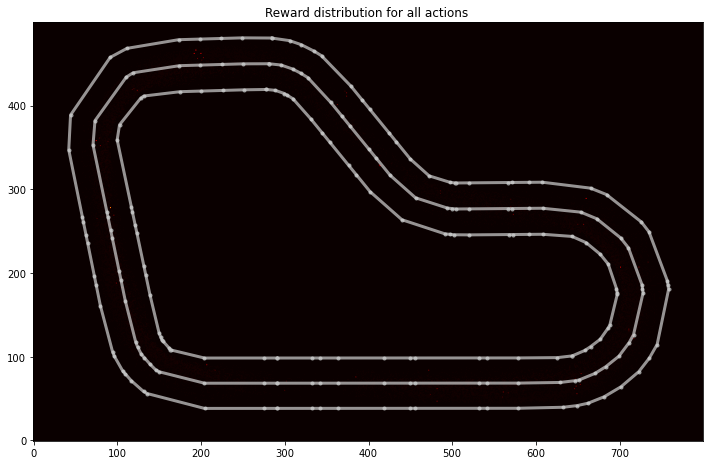

In [78]:
# Some tracks have negative coordinates for which `la.plot_track` is not ready. It has been improved
# using RichardFan's modification to offer an x_shift and y_shift parameters. They may require
# different values for other tracks. You will then need to change it in the future. Simply add parameters:
# track_size=(700,1000), y_shift=300 to this method
track = la.plot_track(df, l_center_line, l_inner_border, l_outer_border)
plt.title("Reward distribution for all actions ")
im = plt.imshow(track, cmap='hot', interpolation='bilinear', origin="lower") 

### Plot a particular iteration
This is same as the heatmap above, but just for a single iteration.

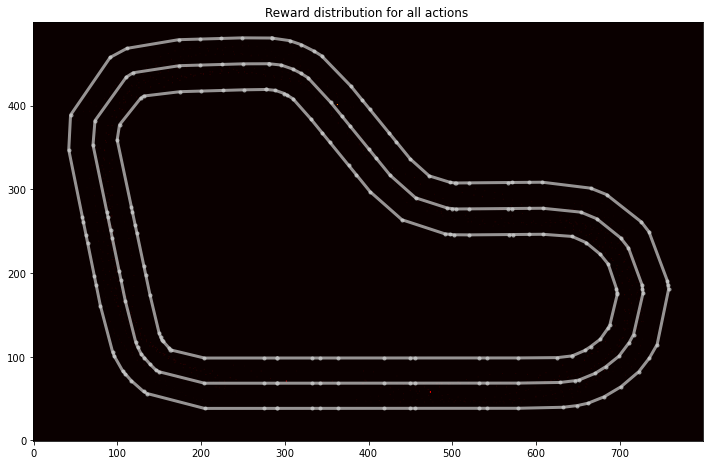

In [79]:
iteration_id = 10
track = la.plot_track(df[df['iteration'] == iteration_id], l_center_line, l_inner_border, l_outer_border)
plt.title("Reward distribution for all actions ")
im = plt.imshow(track, cmap='hot', interpolation='bilinear', origin="lower") 

# Action breakdown per iteration and historgram for action distribution for each of the turns - reinvent track

This plot is useful to understand the actions that the model takes for any given iteration. Unfortunately at this time it is not fit for purpose as it assumes six actions in the action space and has other issues. It will require some work to get it to done but the information it returns will be very valuable.

This is a bit of an attempt to abstract away from the brilliant function in the original notebook towards a more general graph that we could use. It should be treated as a work in progress. The track_breakdown could be used as a starting point for a general track information object to handle all the customisations needed in methods of this notebook.

A breakdown track data needs to be available for it. If you cannot find it for the desired track, MAKEIT.

Currently supported tracks:

In [80]:
la.track_breakdown.keys()

dict_keys(['reinvent2018', 'london_loop'])

The second parameter is either a single index or a list of indices for df iterations that you would like to view. You can for instance use `sorted_idx` list which is a sorted list of iterations from the highest to lowest reward.

Bear in mind that you will have to provide a proper action naming in parameter `action_names`, this function assumes only six actions by default. I think they need to match numbering of actions in your model's metadata json file.

<AxesSubplot:>

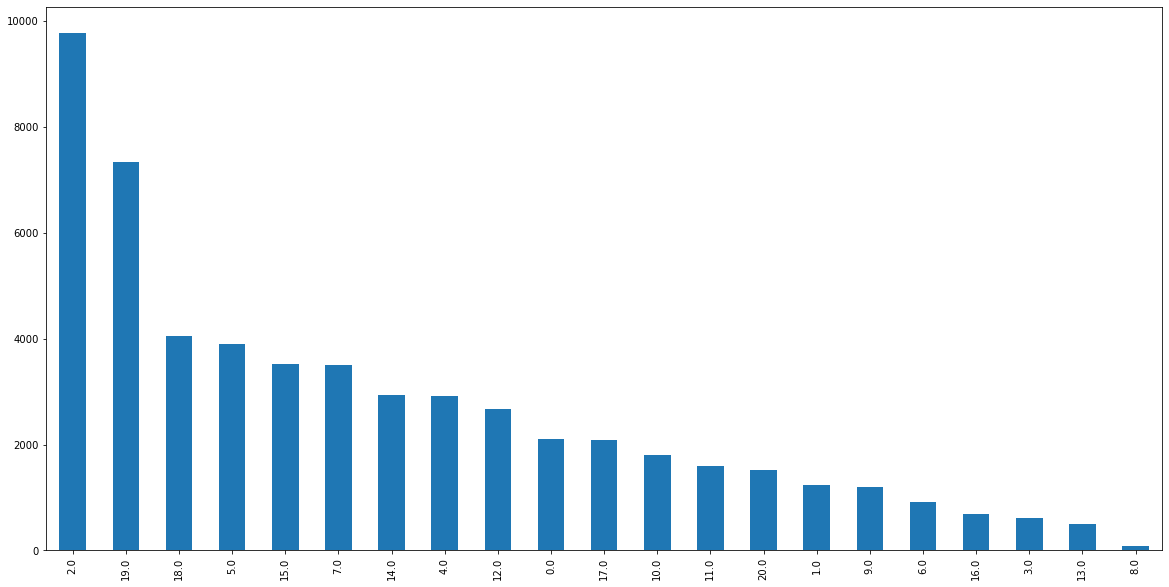

In [81]:
df[df['progress']<=100]['action'].value_counts().plot(kind='bar',figsize=(20,10))

Number of steps in iteration= 54906


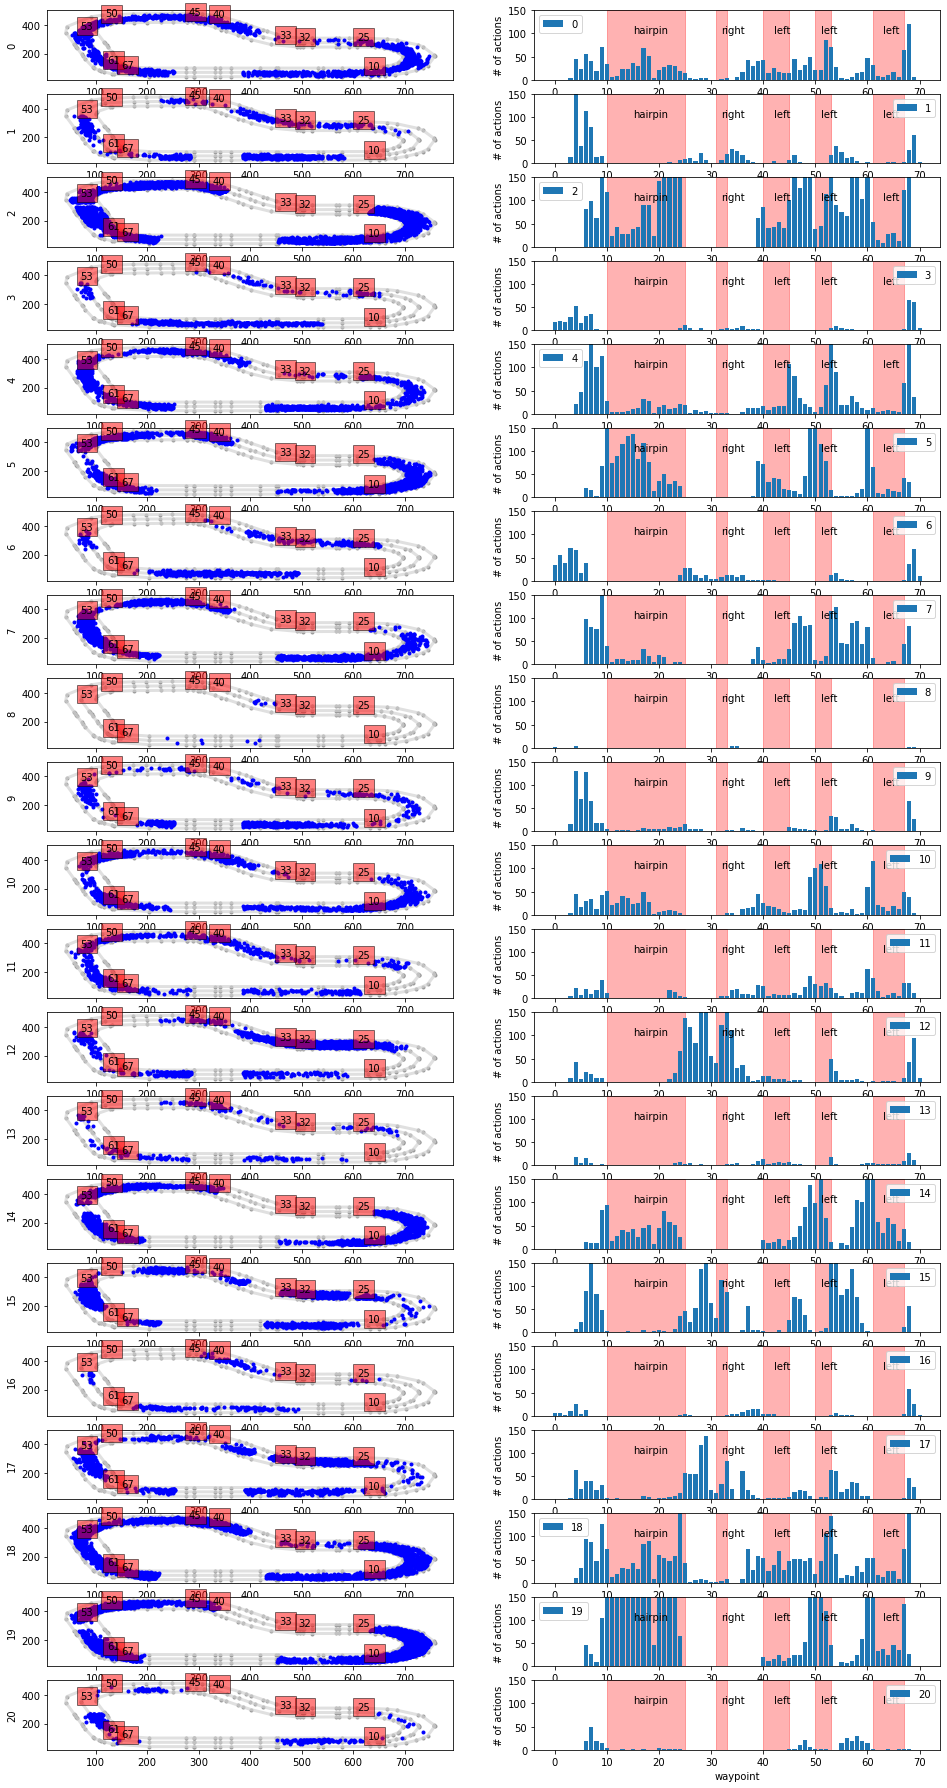

<Figure size 432x288 with 0 Axes>

In [82]:
la.action_breakdown(df, 4,df['iteration'], la.track_breakdown['reinvent2018'], l_center_line, l_inner_border, l_outer_border, ['0', '1', '2', '3',
                                   '4', '5', '6', '7', 
                                   '8', '9', '10', '11', 
                                   '12', '13', '14', '15',
                                   '16', '17', '18', '19', '20'])